In [1]:
import sys
import random
from mysvm import SVM
import numpy as np
from sklearn.linear_model import SGDClassifier as SGD
from pyspark import SparkContext,SparkConf
from sklearn.base import copy

# Spark with SGDClassifier

In [2]:
def fit_in(x,svm):
    for it in x:
        X=it[:-1].reshape(1,it.shape[0]-1)
        y=np.array([it[-1]])
        svm.partial_fit(X,y,classes=[-1,1])
    yield svm
def update_in(m1,m2):
    new_mod=copy.deepcopy(m1)
    new_mod.coef_+=m2.coef_
    new_mod.intercept_+=m2.intercept_
    return new_mod

def avg_coefs_in(svm,numpart):
    svm.coef_/=numpart
    svm.intercept_/=numpart
    return svm

In [3]:
conf=SparkConf().setAppName("SVM-SGD").setMaster('local[4]')

In [4]:
sc=SparkContext(conf=conf)

In [87]:
X1=5*np.random.random((200,2))-3
y1=-1*np.ones(X1.shape[0])
X2=6*(np.random.random((200,2)))+7
y2=np.ones(X2.shape[0])
y=np.hstack((y1,y2))
X=np.vstack((X1,X2))
y=y.reshape(y.shape[0],1)
X=np.hstack((X,y))

In [15]:
svm=SGD(alpha=1,learning_rate='constant',eta0=0.01)

In [16]:
for i in range(200):
    dat=sc.parallelize(X)
    svm=dat.mapPartitions(lambda x:fit_in(x,svm)).reduce(lambda m1,m2:update_in(m1,m2))
    svm=avg_coefs_in(svm,dat.getNumPartitions())
    np.random.shuffle(X)
print(svm.coef_)
print(svm.intercept_)

[[0.14655642 0.1569677 ]]
[-1.4]


## Spark with my implementation of SVM using SGD

In [8]:
def fit(x,svm):
    for it in x:
        X=it[:-1].reshape(1,it.shape[0]-1)
        y=np.array([it[-1]])
        svm.partial_fit(X,y)
    yield svm
def update(m1,m2):
    new_mod=copy.deepcopy(m1)
    new_mod.weights+=m2.weights
    new_mod.intercept+=m2.intercept
    return new_mod

def avg_coefs(svm,numpart):
    svm.weights/=numpart
    svm.intercept/=numpart
    return svm

In [90]:
max_iter=370
l=0.01
alpha=0.01

sv=SVM(alpha,max_iter,l)

In [91]:
for i in range(max_iter):
    dat=sc.parallelize(X)
    sv=dat.mapPartitions(lambda x:fit(x,sv)).reduce(lambda m1,m2:update(m1,m2))
    sv=avg_coefs(sv,dat.getNumPartitions())
    np.random.shuffle(X)
print(sv.weights)
print(sv.intercept)

[0.1758067  0.19020068]
-1.7400000000000002


In [92]:
import seaborn as sns

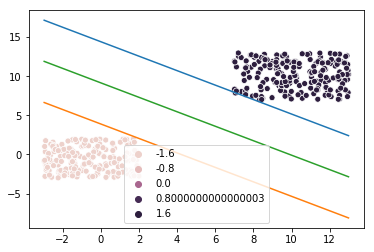

In [93]:
y=sv.hyperplane_coord(X[:,:-1])
s1=sv.support_vec(X[:,:-1],1)
s2=sv.support_vec(X[:,:-1],-1)
sns.scatterplot(X[:,0],X[:,1],hue=X[:,-1])
sns.lineplot(X[:,0],s1)
sns.lineplot(X[:,0],s2)
sns.lineplot(X[:,0],y)